In [1]:
import numpy as np
import pandas as pd
import comonotonic as cm
import naiveBayes as nb
import os
from sklearn.model_selection import train_test_split
import copy
import utils
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Note that we assume the last column is the label
# If the first column is ID's, remove it
filename = "adult.csv"
random_state = 24
df = pd.read_csv("Datasets/"+filename)
# education and education.num is actually the same, so drop "education"
colnames = [('X'+str(i)) for i in range(df.shape[1]-1)]
colnames.append('Y')
df.columns = colnames

In [3]:
colname_dict = {'X0':"age", 'X1': 'workclass', 'X2': 'fnlwgt', 'X3': 'education', 'X4': 'education.num', 'X5': 'marital.status',
                'X6': 'occupation', 'X7': 'relationship', 'X8': 'race', 'X9': 'sex', 'X10': 'capital.gain', 'X11': 'capital.loss', 
                'X12': 'hours.per.week', 'X13': 'native.country', 'Y': 'income'}

In [4]:
#data cleaning for adult.csv
df = df[df.X1 != '?']
df = df[df.X6 != '?']
# unrankable features
encoded_df = utils.encode_df(df, [1,5,6,7,8,9,13])


encoded_df.loc[(encoded_df.Y == "<=50K"),'Y'] = 0
encoded_df.loc[(encoded_df.Y == ">50K"),'Y'] = 1

encoded_df.loc[(encoded_df.X4 <= 9),'X3'] = 0
encoded_df.loc[(encoded_df.X4 == 10),'X3'] = 1
encoded_df.loc[(encoded_df.X4 == 11),'X3'] = 2
encoded_df.loc[(encoded_df.X4 == 12),'X3'] = 2
encoded_df.loc[(encoded_df.X4 >= 13),'X3'] = 3

encoded_df = encoded_df.astype('int32')

In [5]:
# continuous variables; categorical rankable features are [3]
cont_col = [0,2,4,10,11,12]
# unrankable columns
unrankable = [1,5,6,7,8,9,13]
discrete_col = [1,3,5,6,7,8,9,13]
discrete_feature_val = {k:encoded_df['X'+str(k)].nunique() for k in discrete_col}

{1: 7, 3: 4, 5: 7, 6: 14, 7: 6, 8: 5, 9: 2, 13: 42}

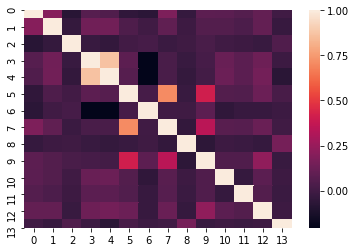

In [6]:
# make sure whether it is proper to construct some columns by yourself

test_df = encoded_df.copy()
test_df = test_df.drop(['Y'], axis = 1)
# test_df['X13'] = test_df.apply(lambda row: 0.2*row.X2+0.5*row.X9-row.X10, axis = 1)
# test_df['X14'] = test_df.apply(lambda row: 1.4*row.X9+3.8*row.X10, axis = 1)
X = test_df.to_numpy()

corr = np.corrcoef(X.T)
ax = sns.heatmap(corr)


In [7]:
# clustered comonotonic
clus_X = encoded_df[colnames[:-1]].to_numpy()
clus_Y = encoded_df[colnames[-1]].to_numpy()
clus_X_train, clus_X_test, clus_Y_train, clus_Y_test = train_test_split(clus_X, clus_Y, test_size = 0.2,
                                                                        random_state = random_state)

clf = cm.clustered_comonotonic(clus_X_train, clus_Y_train, discrete_feature_val, cont_col, unrankable, 0.7, random_state)
clf.run_cluster()


In [13]:
clus_y_predict = clf.cluster_predict(clus_X_test)
utils.get_accuracy(clus_Y_test, clus_y_predict)


0.7828776041666666

In [9]:
# comparation with Naive Bayes
# use the original data for Naive Bayes
original_X = encoded_df[colnames[:-1]].to_numpy()
original_Y = encoded_df[colnames[-1]].to_numpy()
original_X_train, original_X_test, original_Y_train, original_Y_test = train_test_split(original_X, original_Y, test_size=0.2, 
                                                                                        random_state=random_state)

In [10]:
# implementation of NB from scratch
nb_classifier = nb.naive_bayes(original_X_train, original_Y_train, cont_col)
nb_classifier.run()
nb_y_predict = nb_classifier.predict(original_X_test)
utils.get_accuracy(nb_y_predict, original_Y_test)

0.8299153645833334

In [19]:
# weighted average of naive bayes and cluster comonotonic
weighted_predict_y = []
for i in range(len(clus_X_test)):
    prob_dist_cluster_como = clf.get_cluster_prob_dist_single(clus_X_test[i])
    predicted_class, prob_dist_nb = nb_classifier.predict_single(original_X_test[i])
    weighted_predict_y.append(utils.weighted_avg(prob_dist_nb, prob_dist_cluster_como, 2))
#     print(prob_dist_cluster_como)
#     print(prob_dist_nb)
#     print("------")
print(utils.get_accuracy(weighted_predict_y, clus_Y_test))

0.8211263020833334


In [21]:
import operator
both_correct = 0
both_wrong = 0
nb_correct = 0
clus_correct = 0
for i in range(len(clus_X_test)):
    prob_dist_cluster_como = clf.get_cluster_prob_dist_single(clus_X_test[i])
    nb_result, prob_dist_nb = nb_classifier.predict_single(original_X_test[i])
    clus_result = max(prob_dist_cluster_como.items(), key=operator.itemgetter(1))[0]
    if str(clus_result) == str(nb_result) == str(clus_Y_test[i]):
        both_correct += 1
    elif (str(clus_result) == str(nb_result)) and (str(nb_result) != str(clus_Y_test[i])):
        both_wrong += 1
    elif (str(clus_result) != str(nb_result)) and (str(nb_result) == str(clus_Y_test[i])):
        nb_correct += 1
    elif (str(clus_result) != str(nb_result)) and (str(clus_result) == str(clus_Y_test[i])):
        clus_correct += 1

In [22]:
print("Both Correct: " + str(both_correct/len(clus_X_test)))
print("Both Wrong: " + str(both_wrong/len(clus_X_test)))
print("nb Correct: " + str(nb_correct/len(clus_X_test)))
print("clus Correct: " + str(clus_correct/len(clus_X_test)))

Both Correct: 0.734375
Both Wrong: 0.12158203125
nb Correct: 0.09554036458333333
clus Correct: 0.048502604166666664
